# Phase 1 - Preparation Phase

In [1]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib

import sklearn as sk
from sklearn.neural_network import MLPClassifier

#Importing libraries for Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve

from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import graphviz
import pydot
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

sb.set() # set the default Seaborn style for graphics
from pandas import DataFrame
from IPython.display import display
from pandas.api.types import CategoricalDtype
%matplotlib inline
sb.set(rc={'figure.figsize':(11.7,8.27)})

import itertools
from scipy.stats import norm
import scipy.stats
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
from sklearn import datasets
from sklearn.datasets import dump_svmlight_file
import joblib
from sklearn.metrics import precision_score

from sklearn import svm

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

#Importing dataset Cleandata.csv that was previously cleaned
aviation_data = 'cleandata.csv'
AviationData = pd.read_csv(aviation_data, sep=',', header=0, encoding = 'iso-8859-1')
AviationData.head()

,Unnamed: 0,Event.Date,Country,Latitude,Longitude,Airport.Code,Aircraft.Damage,Aircraft.Category,Make,Model,...,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Month,Year,Time,Total.Passengers,Num_Aircraft_Damage,Severity.Score,Severity_Class
0,0,31/12/2019,United States,39.128611,-123.715833,LLR,Substantial,Airplane,CESSNA,175,...,1.0,VMC,TAKEOFF,12,2019,2019-12,1.0,0.9,1.125000,1
1,1,31/12/2019,United States,38.846111,-94.736111,OJC,Destroyed,Airplane,MOONEY,M20S,...,0.0,VMC,TAKEOFF,12,2019,2019-12,2.0,1.0,10.000000,3
2,2,31/12/2019,United States,64.666945,-148.133334,XXX,Substantial,Airplane,CESSNA,170,...,2.0,UNK,UNKNOWN,12,2019,2019-12,2.0,0.9,1.125000,1
3,3,30/12/2019,United States,32.365556,-97.645000,XXX,Substantial,Airplane,VANS,RV 10,...,1.0,UNK,UNKNOWN,12,2019,2019-12,1.0,0.9,1.125000,1
4,5,28/12/2019,United States,30.176111,-92.007500,LFT,Destroyed,Airplane,PIPER,PA 31T,...,0.0,IMC,TAKEOFF,12,2019,2019-12,9.0,1.0,7.277778,2


In [2]:
#Displaying all columns available
AviationData.columns

Index(['Unnamed: 0', 'Event.Date', 'Country', 'Latitude', 'Longitude',
       'Airport.Code', 'Aircraft.Damage', 'Aircraft.Category', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type',
       'Purpose.of.Flight', 'Total.Fatal.Injuries', 'Total.Serious.Injuries',
       'Total.Minor.Injuries', 'Total.Uninjured', 'Weather.Condition',
       'Broad.Phase.of.Flight', 'Month', 'Year', 'Time', 'Total.Passengers',
       'Num_Aircraft_Damage', 'Severity.Score', 'Severity_Class'],
      dtype='object')

## Compiling Data for Multivariate Tree

### One-Hot Encoding for Nominal Categorical Variables

In [2]:
#Displaying the top 10 Make of aircraft by value
AviationData["Make"].value_counts().head(10)

CESSNA       8587
PIPER        4833
BEECH        1813
BELL          825
MOONEY        490
ROBINSON      474
BOEING        348
BELLANCA      310
SCHWEIZER     289
HUGHES        283
Name: Make, dtype: int64

In [3]:
#Displaying the top 10 Model of aircraft by value
AviationData["Model"].value_counts().head(10)

172          623
152          476
172N         369
172S         340
172M         266
PA-28-140    251
180          250
182          229
A36          225
PA-18-150    223
Name: Model, dtype: int64

In [4]:
#Creating a list using the Top to Model and Make of Aircraft
TenCompanies = ['CESSNA', 'PIPER', 'BEECH', 'BELL', 'MOONEY', 'BOEING', 'ROBINSON', 'BELLANCA', 'SCHWEIZER', 'HUGHES']
TenModels = ['172', '152', '172S', '172N', '172M ','180', '182', 'PA-28-140', 'A36', 'SR22']

#Creating function to reassign all other make and model with "OTHER"
def return_company(row):
    if row['Make'] in TenCompanies:
        Make = row['Make']
    else:
        Make ='OTHER'
    return Make
    
def return_model(row):
    if row['Model'] in TenModels:
        Model = row['Model']
    else:
        Model ='OTHER'
    return Model

#Updating the dataset
AviationData = AviationData.assign(Make_10 = AviationData.apply (lambda row: return_company(row), axis=1))
AviationData = AviationData.assign(Model_10 = AviationData.apply (lambda row: return_model(row), axis=1))

In [5]:
#Filtering predictors into a Dataframe
AllPredictors = pd.DataFrame(AviationData[['Make_10', 'Model_10','Engine.Type','Amateur.Built','Broad.Phase.of.Flight', 'Year', 'Month', 'Weather.Condition', 'Purpose.of.Flight', 'Aircraft.Category', 'Number.of.Engines', 'Severity.Score', 'Severity_Class']])
AllPredictors = AllPredictors.fillna(0)
AllPredictors[['Year', 'Month', 'Number.of.Engines', 'Severity_Class']] = AllPredictors[['Year', 'Month', 'Number.of.Engines', 'Severity_Class']].astype('category')

#### <font color=#800020>In the next step the 11 predictor variables will get converted to one-hot to be able to be fitted into the classifier and regression.</font>

In [6]:
#One-hot encoding on nominal categorical variables
AllPredictors = pd.get_dummies(AllPredictors,prefix = ['Make_10','Model_10','Engine.Type','Amateur.Built', 'Broad.Phase.of.Flight', 'Year', 'Month', 'Weather.Condition','Purpose.of.Flight', 'Aircraft.Category', 'Number.of.Engines', 'Severity_Class'])
AllPredictors['Severity_Class'] = AviationData['Severity_Class']
AllPredictors.shape

(31403, 129)

In [8]:
#Storing encoded data as a csv
AllPredictors.to_csv("predictors.csv",index=False)

# Phase 2 - Choosing Algorithm

## Phase 2a - Regression

## Spliting the data for  Regression

#### <font color=#800020>For random forest regression, the response variable used would be severity score which is a continuous variable. Severity class is will dropped in this case as well as it will be used as the response variable for classification in the next part.</font>

In [9]:
# Labels are the values we want to predict
labels = np.array(AllPredictors['Severity.Score'])

# Remove the labels from the features
# axis 1 refers to the columns
features = AllPredictors.drop(['Severity.Score','Severity_Class_1', 'Severity_Class_2', 'Severity_Class_3', 'Severity_Class'], axis = 1)

featuresdfR = features
# Saving feature names for later use
feature_list_R = list(features.columns)

# Convert to numpy array
featuresR = np.array(features)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, random_state = 50)

#### <font color=#800020>The tree for regression is split on a 80:20 train to test ratio and the parameters used are n_estimators=500 and random_state=50. Random state is configured to 50 throughout this project to maintain consistancy in the results.</font>

In [10]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=500, random_state=0)
regressor.fit(train_features, train_labels)
y_pred_R = regressor.predict(test_features)

In [11]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, y_pred_R))
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, y_pred_R))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, y_pred_R)))

Mean Absolute Error: 1.8868115358368314
Mean Squared Error: 7.818728084717957
Root Mean Squared Error: 2.7961988635856994


#### <font color=#800020>The MAE and MSE are considerably high, considering that we have a small range of Severity Score only from 1 to 10. The RMSE is significantly higher that the MAE, hinting that we may have many significant outliers. As such we can observe that the model created may not be a very good fit on the test set.</font>

In [12]:
feature_importances_R = pd.DataFrame(regressor.feature_importances_,
                                   index = featuresdfR.columns ,
                                    columns=['importance']).sort_values('importance', ascending=True)
feature_importances_R.nlargest(10,"importance")

,importance
Broad.Phase.of.Flight_LANDING,0.113561
Weather.Condition_IMC,0.067259
Broad.Phase.of.Flight_MANEUVERING,0.028697
Purpose.of.Flight_Personal,0.022700
Month_8,0.019263
Month_7,0.019025
Month_5,0.018484
Month_6,0.017810
Month_9,0.017796
Month_4,0.017128


#### <font color=#800020>The first 4 variable actually shed some light on the important features but the next 6 are more generic features.</font>

In [13]:
regressor.score(test_features, test_labels)

0.16206514757057267

#### <font color=#800020>Having a R^2 value of 0.1621 shows that our model is <b>not</b> a good fit. We will compare this score to the score of the RF classifier before determining whether regression or classification may be more benefit for the model.</font>

## Phase 2b - Classification

## Spliting the data for Classification

#### <font color=#800020>Similar to RF regression, an 80 to 20, train to test ratio is used. The only difference in the forest would be the response variable. In RF classification, we fitted the severity score into 3 classes (Classes 1, 2 and 3) and used it as the response variable.</font>

In [7]:
# Labels are the values we want to predict
labelsC = np.array(AllPredictors['Severity_Class'])

# Remove the labels from the features
# axis 1 refers to the columns
featuresC = AllPredictors.drop(['Severity.Score','Severity_Class_1', 'Severity_Class_2', 'Severity_Class_3', 'Severity_Class'], axis = 1)

featuresdf = featuresC
# Saving feature names for later use
feature_list = list(featuresC.columns)


# Convert to numpy array
featuresC = np.array(featuresC)

# Split the data into training and testing sets
train_featuresC, test_featuresC, train_labelsC, test_labelsC = train_test_split(featuresC, labelsC, test_size = 0.20, random_state = 50)

#### <font color=#800020>The data split above will be used to run most of the algorithms that we will be using below.</font>

### Random Forest Classification Algorithm

In [8]:
# Fitting the classifier to the Training set
model = RandomForestClassifier(n_estimators=500, criterion='gini', random_state = 50)
model.fit(train_featuresC, train_labelsC)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In [16]:
#Retrieving the important determining features from the random forest
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = featuresdf.columns ,
                                    columns=['importance']).sort_values('importance', ascending=True)
feature_importances.nlargest(8,"importance")

,importance
Broad.Phase.of.Flight_LANDING,0.068656
Month_7,0.023634
Month_6,0.023275
Month_8,0.023192
Month_5,0.022763
Broad.Phase.of.Flight_MANEUVERING,0.022333
Month_9,0.020774
Month_4,0.020661


#### <font color=#800020>The feature importance contains 6 "month" data and 2 "Broad phase of flight data". This could be interesting be the importance percentage is rather low with most just slightly above 2%</font>

In [9]:
# Predicting the test set result
y_pred = model.predict(test_featuresC)

(3, 0)

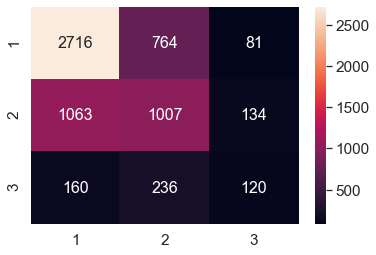

In [18]:
# Making the confusion matrix
cm = confusion_matrix(test_labelsC, y_pred)

sb.set(font_scale=1.4) # for label size
ax = sb.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 16}, xticklabels = [1,2,3], yticklabels = [1,2,3]) # font size
ax.set_ylim(len(cm), 0)
#ax.figure.savefig('Forest_CM.png', dpi=300,transparent=True)

In [19]:
# Getting the score for our model
model.score(test_featuresC, test_labelsC)

0.6118452475720426

In [20]:
rfc_cv_score = cross_val_score(model, featuresC, labelsC, cv=2, scoring='accuracy')

In [21]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labelsC, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labelsC, y_pred))
print('\n')
print("=== All Accuracy Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean Accuracy Score ===")
print("Mean Accuracy Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[2716  764   81]
 [1063 1007  134]
 [ 160  236  120]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.69      0.76      0.72      3561
           2       0.50      0.46      0.48      2204
           3       0.36      0.23      0.28       516

    accuracy                           0.61      6281
   macro avg       0.52      0.48      0.49      6281
weighted avg       0.60      0.61      0.60      6281



=== All Accuracy Scores ===
[0.57307521 0.27140127]


=== Mean Accuracy Score ===
Mean Accuracy Score - Random Forest:  0.4222382412221122


#### <font color=#800020>From the classification report, the general trend would be that class 1 would have the highest accuracy and class 3 would have the lowest. From the support column it could be seen that this is perhaps due to the dataset not being spread out sufficiently. As our assignment of severity class is from a preset formula in data preparation phase, if there is a different definition is the future, the formula can be adjusted and the data will change accordingly. </font>

## Phase 2c - Tuning

### Extremely Randomized Trees Classifier (Extra Trees)

In [22]:
#Double checking random forest with 
extra = ExtraTreesClassifier(criterion='gini', random_state = 50)
extra.fit(train_featuresC, train_labelsC)
#print(extra.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
extra.score(test_featuresC, test_labelsC)

C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5932176405031045

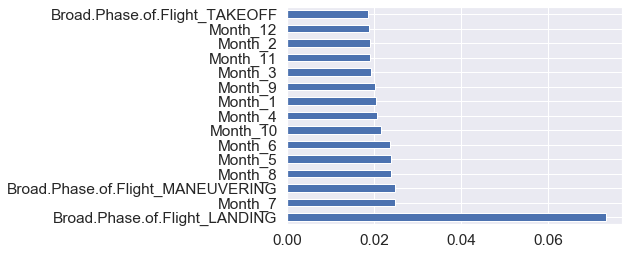

In [23]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(extra.feature_importances_,  index = featuresdf.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

#### <font color=#800020>Extra tree is very similar to Random forest classification in terms of accuracy with the exception in bootstrapping. We used extra tree to generate result quickly when running tuning and validation of results.</font>

### Tuning the Random Forest

In [12]:
num_maxdepth = [11,14,17,20]

train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = train_featuresC, y = train_labelsC, 
                                param_name = 'max_depth', 
                                param_range = num_maxdepth, cv = 3)

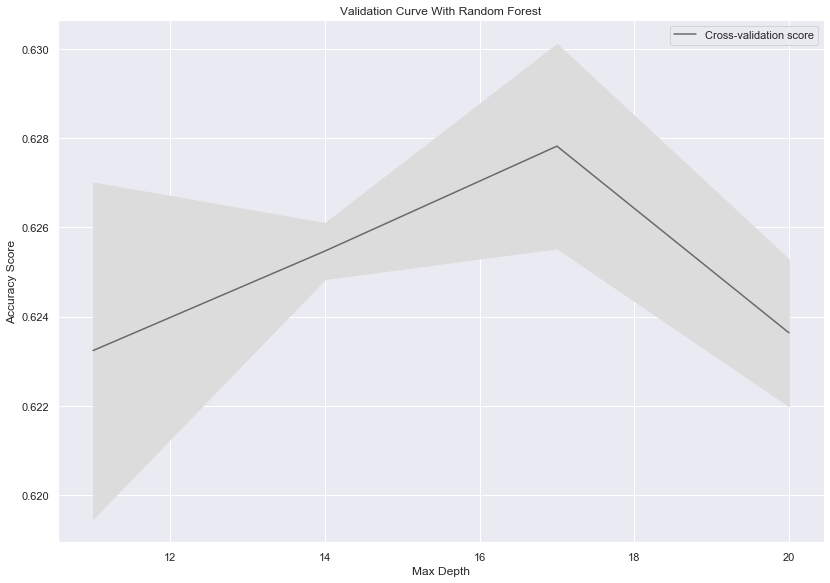

In [13]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
#plt.plot(num_maxfeatures, train_mean, label="Training score", color="black")
plt.plot(num_maxdepth, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
#plt.fill_between(num_maxfeatures, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(num_maxdepth, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### <font color=#800020>Tuning max depth could be slightly tricky as if the depth is too much it may result in overfitting which is a common problem in this case. The max depth for our tuned tree is picked using the highest peak in the curve, which is 17. To be sure that the validation curve gives us the best result, we manually ran through the depths using our model to ensure we get the best accuracy</font>

In [26]:
num_minsamplessplit = [5,10,15,20]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = train_featuresC, y = train_labelsC, 
                                param_name = 'min_samples_split', 
                                param_range = num_minsamplessplit, cv = 3)

C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

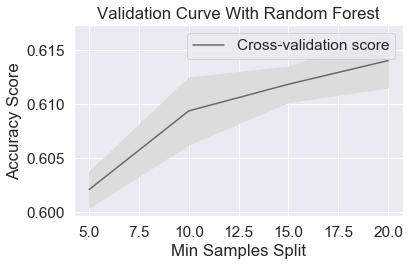

In [27]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
#plt.plot(num_maxfeatures, train_mean, label="Training score", color="black")
plt.plot(num_minsamplessplit, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
#plt.fill_between(num_maxfeatures, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(num_minsamplessplit, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Min Samples Split")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### <font color=#800020>For Min samples split, although the curve continues to increase, we chose 10 as the min sample split as having a larger number could result in more general nodes in the tree.</font>

In [28]:
num_maxEst = [500, 750, 800, 1200]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = train_featuresC, y = train_labelsC, 
                                param_name = 'n_estimators', 
                                param_range = num_maxEst, cv = 3)

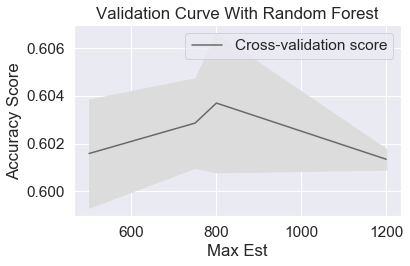

In [29]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
#plt.plot(num_maxfeatures, train_mean, label="Training score", color="black")
plt.plot(num_maxEst, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
#plt.fill_between(num_maxfeatures, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(num_maxEst, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max Est")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### <font color=#800020>For n_estimate, we tried running the random forest classifier with n_estimator from 600 to 1000 with increment of 50 and we realised although the peak is at 800, 750 gave us the best results. We are extremely glad the optimal n value was 750 as it did not take too much processing power to run through 750 trees. On the side note, one of our team mates tried running 5000 trees. It took 50 minutes but the overall accuracy and feature importance deteriorated :(. </font>

In [30]:
num_maxfeatures = [5, 10, 15, 20] 
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = train_featuresC, y = train_labelsC, 
                                param_name = 'max_features', 
                                param_range = num_maxfeatures, cv = 3)

C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Irvin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

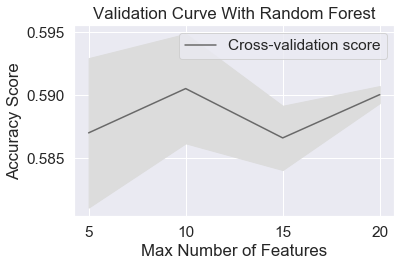

In [31]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
#plt.plot(num_maxfeatures, train_mean, label="Training score", color="black")
plt.plot(num_maxfeatures, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
#plt.fill_between(num_maxfeatures, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(num_maxfeatures, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max Number of Features")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### <font color=#800020>For max feature, we chose 10 as it performs the best and it is a good balance better performance and speed</font>

In [18]:
num_minsamplesleaf = [2, 4, 6, 8, 10] 
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = train_featuresC, y = train_labelsC, 
                                param_name = 'min_samples_leaf', 
                                param_range = num_minsamplesleaf, cv = 3)

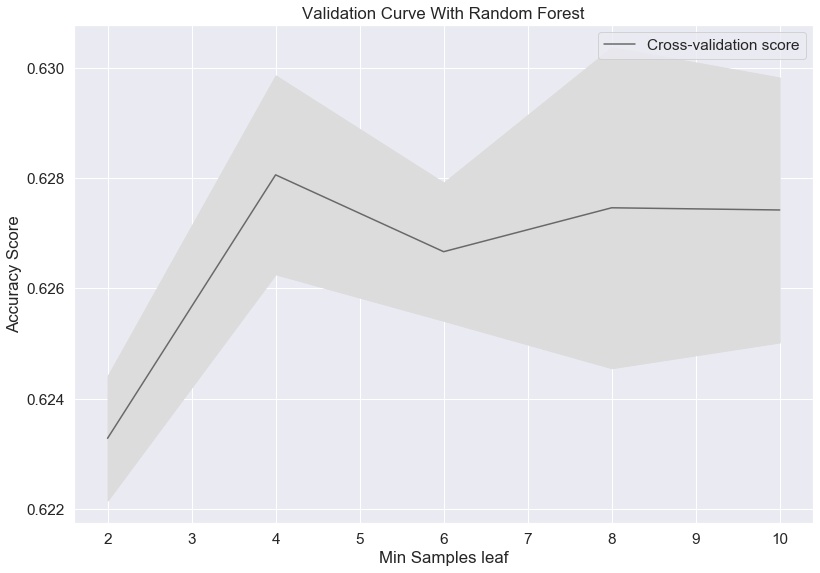

In [19]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
#plt.plot(num_maxfeatures, train_mean, label="Training score", color="black")
plt.plot(num_minsamplesleaf, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
#plt.fill_between(num_maxfeatures, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(num_minsamplesleaf, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Min Samples leaf")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### <font color=#800020>We picked the optimum min sample leaf as 4 in this case as a larger leaf size could case overfitting and a minimum of 4 leaf gives us the best performance.</font>

In [34]:
# Fitting the classifier to the Training set
model = RandomForestClassifier(n_estimators=750, random_state = 50,max_features = 10, max_depth = 17,min_samples_split = 10,min_samples_leaf = 4)
model.fit(train_featuresC, train_labelsC)
model.score(test_featuresC, test_labelsC)

0.6495780926604044

#### <font color=#800020>Compared the the previous score of 0.612, there is a 3.8 percent increased in accuracy score</font>

In [35]:
#Retrieving the important determining features from the random forest
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = featuresdf.columns ,
                                    columns=['importance']).sort_values('importance', ascending=True)
feature_importances.nlargest(8,"importance")

,importance
Broad.Phase.of.Flight_LANDING,0.252536
Broad.Phase.of.Flight_MANEUVERING,0.068755
Weather.Condition_IMC,0.045828
Broad.Phase.of.Flight_TAXI,0.044587
Weather.Condition_VMC,0.043854
Broad.Phase.of.Flight_APPROACH,0.026910
Broad.Phase.of.Flight_TAKEOFF,0.023151
Amateur.Built_Yes,0.022040


#### <font color=#800020>There is a huge change in feature importance and "months" completely disappeared from the list</font>

In [36]:
# Predicting the test set result
y_pred = model.predict(test_featuresC)

(3, 0)

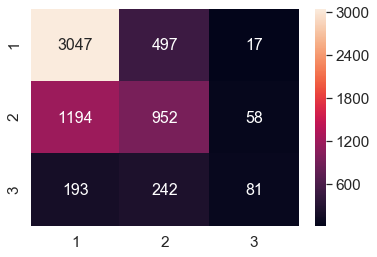

In [37]:
# Making the confusion matrix
cm = confusion_matrix(test_labelsC, y_pred)

sb.set(font_scale=1.4) # for label size
ax = sb.heatmap(cm, annot=True, fmt='g',annot_kws={"size": 16}, xticklabels = [1,2,3], yticklabels = [1,2,3]) # font size
ax.set_ylim(len(cm), 0)
#ax.figure.savefig('Forest_CM.png', dpi=300,transparent=True)

In [38]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labelsC, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labelsC, y_pred))
print('\n')

=== Confusion Matrix ===
[[3047  497   17]
 [1194  952   58]
 [ 193  242   81]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.69      0.86      0.76      3561
           2       0.56      0.43      0.49      2204
           3       0.52      0.16      0.24       516

    accuracy                           0.65      6281
   macro avg       0.59      0.48      0.50      6281
weighted avg       0.63      0.65      0.62      6281





#### <font color=#800020>The is an improvement in the classification for class 1 and 2 when comparing precision, recall and F1-score. But class 3 shows a drop which could be due to the spread of the data.</font>

In [39]:
feature_importances.to_csv('importance.csv')

# Phase 4 - Using different algorithms as a bench

### TensorFlow Neural Network

In [40]:
# Labels are the values we want to predict
labelsC = np.array(AllPredictors[['Severity_Class_1', 'Severity_Class_2', 'Severity_Class_3']])

# Remove the labels from the features
# axis 1 refers to the columns
featuresC = AllPredictors.drop(['Severity.Score','Severity_Class_1', 'Severity_Class_2', 'Severity_Class_3', 'Severity_Class'], axis = 1)

featuresdf = featuresC
# Saving feature names for later use
feature_list = list(featuresC.columns)

# Convert to numpy array
featuresC = np.array(featuresC)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_featuresC, test_featuresC, train_labelsC, test_labelsC = train_test_split(featuresC, labelsC, test_size = 0.20, random_state = 50)

In [41]:
#scaling data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_featuresNN = sc.fit_transform(train_featuresC)
test_featuresNN = sc.transform(test_featuresC)

In [42]:
#Initializing Neural Network
ann_model = Sequential()

# Adding the input layer and the first hidden layer
ann_model.add(Dense(128, init = 'uniform', activation = 'relu', input_dim = 124))
ann_model.add(Dropout(0))

# Adding the second hidden layer
ann_model.add(Dense(128, init = 'uniform', activation = 'relu'))
ann_model.add(Dropout(0))

# Adding the third hidden layer
ann_model.add(Dense(128, init = 'uniform', activation = 'relu'))
ann_model.add(Dropout(0))

# Adding the output layer
ann_model.add(Dense(output_dim = 3, init = 'uniform', activation = 'sigmoid'))

# Compiling Neural Network
ann_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting our model 
ann_model.fit(train_featuresC, train_labelsC, batch_size = 150, epochs = 100)

y_pred = ann_model.predict(test_featuresC)

C:\Users\Irvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", input_dim=124, kernel_initializer="uniform")`
  """
C:\Users\Irvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
C:\Users\Irvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="uniform")`
  del sys.path[0]
C:\Users\Irvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=3, kernel_initializer="uniform")`


Epoch 1/100
25122/25122 [==============================] - 2s 68us/step - loss: 0.5199 - accuracy: 0.7180
Epoch 2/100
25122/25122 [==============================] - 1s 33us/step - loss: 0.4628 - accuracy: 0.7570
Epoch 3/100
25122/25122 [==============================] - 1s 33us/step - loss: 0.4535 - accuracy: 0.7650
Epoch 4/100
25122/25122 [==============================] - 1s 31us/step - loss: 0.4485 - accuracy: 0.7690
Epoch 5/100
25122/25122 [==============================] - 1s 31us/step - loss: 0.4455 - accuracy: 0.7705
Epoch 6/100
25122/25122 [==============================] - 1s 32us/step - loss: 0.4423 - accuracy: 0.7742
Epoch 7/100
25122/25122 [==============================] - 1s 32us/step - loss: 0.4384 - accuracy: 0.7773
Epoch 8/100
25122/25122 [==============================] - 1s 38us/step - loss: 0.4348 - accuracy: 0.7782
Epoch 9/100
25122/25122 [==============================] - 1s 38us/step - loss: 0.4316 - accuracy: 0.7820
Epoch 10/100
25122/25122 [====================

In [43]:
y_pred = (y_pred > 0.5)
loss, accuracy = ann_model.evaluate(test_featuresNN, test_labelsC)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

6281/6281 [==============================] - 0s 78us/step

Loss: 74.70, Accuracy: 71.13%


#### <font color=#800020>TensorFlow by Keras module is able to learn the train set to over 92% accuracy and predict the test set to over 70% accuracy. This is by far the best accuracy we get from all algorithms we have tried. We got this by setting 3 layers and ADAM optimizer on the model. This algorithm reflects on some abstract errors on the dataset. That being said, two aircrafts with the same specifications, landing in a similar weather condition, may result on two different scenarios. These external factors cannot be determined given the limited data we have on our dataset. </font>

### Naive Bayes Classifier

In [44]:
# Labels are the values we want to predict
labelsC = np.array(AllPredictors['Severity_Class'])

# Remove the labels from the features
# axis 1 refers to the columns
featuresC = AllPredictors.drop(['Severity.Score','Severity_Class_1', 'Severity_Class_2', 'Severity_Class_3', 'Severity_Class'], axis = 1)

featuresdf = featuresC
# Saving feature names for later use
feature_list = list(featuresC.columns)


# Convert to numpy array
featuresC = np.array(featuresC)

# Split the data into training and testing sets
train_featuresC, test_featuresC, train_labelsC, test_labelsC = train_test_split(featuresC, labelsC, test_size = 0.20, random_state = 50)

In [45]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(train_featuresC, train_labelsC)

#Predict the response for test dataset
y_pred = gnb.predict(test_featuresC)

In [46]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labelsC, y_pred))

Accuracy: 0.38783633179430027


In [47]:
print(confusion_matrix(test_labelsC, y_pred))

[[1848   60 1653]
 [ 620  119 1465]
 [  38    9  469]]


#### <font color=#800020>It seems that Naive Bayes may not be the best classifier for this case as it is normally used for continuous dataset. We attempted to use Multinomial Naive Bayes as well but we could not determine if it was a fitting algorithm to use as documentation pointed its usage towards text and word based classification. Perhaps it would be something that we can use if we are attempting the jokes dataset. Nevertheless, it was one of the algorithm we explored and something we learnt in the process.</font>

### SKlearn Neural Network

In [55]:
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=50, max_iter=1000)
NN.fit(train_featuresC, train_labelsC)
NN_pred = NN.predict(test_featuresC)
NN.score(test_featuresC, test_labelsC)

0.6303136443241522

In [56]:
print(confusion_matrix(test_labelsC, NN_pred))

[[2664  866   31]
 [ 937 1191   76]
 [  72  340  104]]


#### <font color=#800020>The final results came down to 63.53% which is quite a good accuracy. In this iteration, we used the limited memory BFGS for faster processing as compared to ADAM. The accuracy score is quite good on the initial run but the Neural network is quite complicated and could take some time to tune. In the end we used this as one of the bench for accuracy but it was interesting trying to implement this.</font>

### XgBoost Algorithm

In [50]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(random_state=50)
xgbc.fit(train_featuresC, train_labelsC)
# make predictions for test data
y_pred = xgbc.predict(test_featuresC)
predictions = [round(value) for value in y_pred]
# evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labelsC, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.78%


#### <font color=#800020>XGBoost is actually an interesting algorith as it uses gradient boosting to improve the accuracy of decision trees but could be prone to overfitting. Athough the initial accuracy is actually very close to our tuned forest, we actually tried to tune in hopes it can exceed our forest but didn't get significant result.</font>

### Support Vector Classifier

In [51]:
SVM = svm.SVC(gamma = 'scale', C=10)
SVM.fit(train_featuresC, train_labelsC)
SVM.predict(test_featuresC)
SVM.score(test_featuresC, test_labelsC)

0.6268110173539245

### Support Vector Classifier - Linear method

In [52]:
SVM = svm.SVC(gamma = 'scale', C=10, kernel = 'linear')
SVM.fit(train_featuresC, train_labelsC)
SVM.predict(test_featuresC)
SVM.score(test_featuresC, test_labelsC)

0.642254418086292

#### <font color=#800020>For SVM, we ran both the default kernal RBF and Linear. The reason we ran linear was actually to try to retrieve the feature importance as the rbf kernel does not return feature importance. But due to the both algorithm having lower accuracy score than Random forest, we decided to focus more time on random forest instead.</font>

#### <font color=#800020>In terms of accuracy, TensorFlow by Keras module performed the best. However, we used Random Forest as our main algorithm as Neural network is quite complicated and it would take sometime to perfect the algorithm and return accurate values. Thus, we decided to stick with random forest as our main algorithm. Although, if given more time, we would enjoy exploring more ways to make our data more accurate and get a better prediction</font>